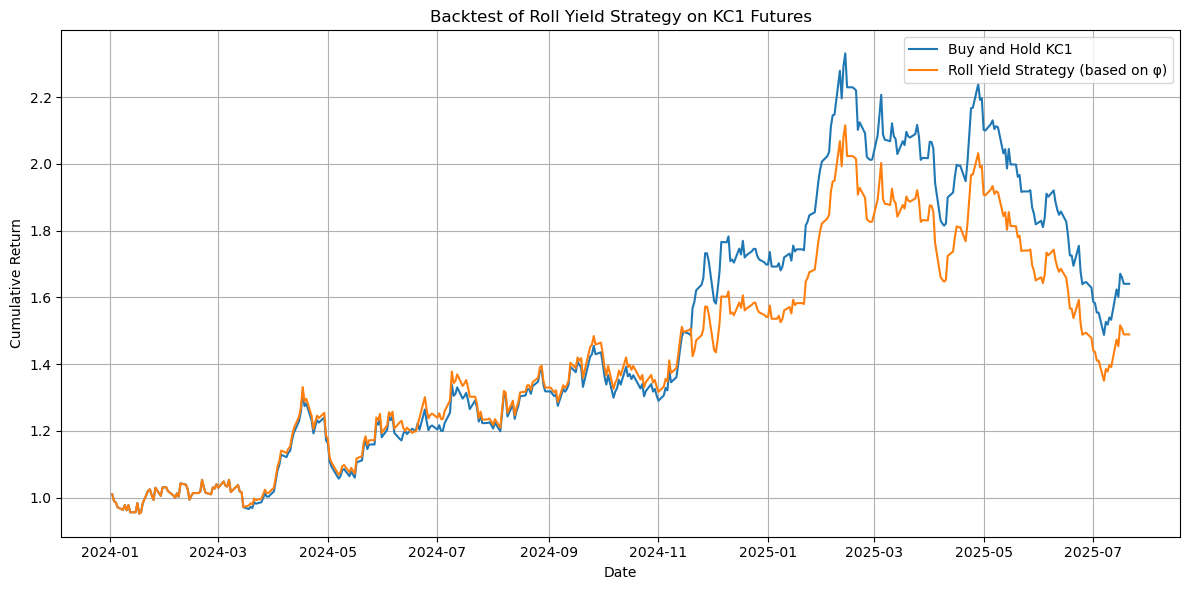

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "KC future one year dataset.xlsx"
xls = pd.ExcelFile(file_path)

# Load KC1 and KC2 futures sheets, skipping metadata rows
kc1 = xls.parse('KC1_Comdty', skiprows=5)
kc2 = xls.parse('KC2_Comdty', skiprows=5)

# Select relevant columns and rename
kc1 = kc1[['Dates', 'PX_LAST']].rename(columns={'PX_LAST': 'KC1_PX'})
kc2 = kc2[['Dates', 'PX_LAST']].rename(columns={'PX_LAST': 'KC2_PX'})

# Convert date columns to datetime
kc1['Dates'] = pd.to_datetime(kc1['Dates'])
kc2['Dates'] = pd.to_datetime(kc2['Dates'])

# Merge KC1 and KC2 by date
df = pd.merge(kc1, kc2, on='Dates', how='inner')
df.sort_values('Dates', inplace=True)

# Calculate roll yield ratio φ = P1 / P2
df['phi'] = df['KC1_PX'] / df['KC2_PX']

# Generate trading signals based on phi
df['Signal'] = 0
df.loc[df['phi'] > 1, 'Signal'] = 1   # Backwardation → Long
df.loc[df['phi'] < 1, 'Signal'] = -1  # Contango → Short

# Calculate returns
df['Return'] = df['KC1_PX'].pct_change()
df['Strategy Return'] = df['Signal'].shift(1) * df['Return']  # shift signal to avoid lookahead bias

# Compute cumulative returns
df['Cumulative Market Return'] = (1 + df['Return']).cumprod()
df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Dates'], df['Cumulative Market Return'], label='Buy and Hold KC1')
plt.plot(df['Dates'], df['Cumulative Strategy Return'], label='Roll Yield Strategy (based on φ)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Backtest of Roll Yield Strategy on KC1 Futures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()